# 01__cis_motif_model

in this notebook, i find motifs whose disruption is significantly associated w/ cis effects using linear models

In [1]:
import warnings
warnings.filterwarnings('ignore')

import itertools
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import sys

from itertools import combinations 
from scipy.stats import boxcox
from scipy.stats import linregress
from scipy.stats import spearmanr
from scipy.stats import pearsonr
from statsmodels.stats.anova import anova_lm

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)

# import utils
sys.path.append("../../../utils")
from plotting_utils import *
from classify_utils import *

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
mpl.rcParams['figure.autolayout'] = False

In [2]:
sns.set(**PAPER_PRESET)
fontsize = PAPER_FONTSIZE

In [3]:
np.random.seed(2019)

In [4]:
QUANT_ALPHA = 0.05

## functions

In [5]:
def calculate_gc(row, col):
    cs = row[col].count("C")
    gs = row[col].count("G")
    gc = (cs+gs)/len(row[col])
    return gc

In [6]:
def calculate_cpg(row, col):
    cpgs = row[col].count("CG")
    cpg = cpgs/len(row[col])
    return cpg

In [7]:
def lrtest(llmin, llmax):
    lr = 2 * (llmax - llmin)
    p = stats.chisqprob(lr, 1) # llmax has 1 dof more than llmin
    return lr, p

## variables

In [8]:
motif_dir = "../../../data/04__mapped_motifs/elem_fimo_out"
motifs_f = "%s/fimo.txt.gz" % motif_dir

In [9]:
elem_map_f = "../../../data/04__mapped_motifs/fastas/elem_map.txt"

In [10]:
motif_info_dir = "../../../misc/01__motif_info"
motif_map_f = "%s/00__lambert_et_al_files/00__metadata/curated_motif_map.txt" % motif_info_dir
motif_info_f = "%s/00__lambert_et_al_files/00__metadata/motif_info.txt" % motif_info_dir

In [11]:
sig_motifs_f = "../../../data/04__mapped_motifs/sig_motifs.txt"

In [12]:
tss_map_f = "../../../data/01__design/01__mpra_list/mpra_tss.with_ids.RECLASSIFIED_WITH_MAX.txt"

In [13]:
index_f = "../../../data/01__design/02__index/TWIST_pool4_v8_final.with_element_id.txt.gz"

In [14]:
data_f = "../../../data/02__mpra/03__results/all_processed_results.txt"

## 1. import data

In [15]:
index = pd.read_table(index_f, sep="\t")
index_elem = index[["element", "tile_type", "element_id", "name", "tile_number", "chrom", "strand", "actual_start", 
                    "actual_end", "dupe_info"]]
index_elem = index_elem.drop_duplicates()

In [16]:
tss_map = pd.read_table(tss_map_f, sep="\t")
tss_map.head()

,hg19_id,mm9_id,cage_id_hg19,cage_id_mm9,name_peak_hg19,name_peak_mm9,biotype_hg19,biotype_mm9,minimal_biotype_hg19,minimal_biotype_mm9,...,stem_exp_mm9,max_cage_hg19,max_cage_mm9,orig_species,har,tss_tile_num_max_hg19,tss_tile_num_max_mm9,n_tiles_hg19,n_tiles_mm9,tile_match
0,h.0,m.0,"chr1:2984976..2984989,-","chr4:154011655..154011673,+",ENSG00000177133.6,ENSMUSG00000085069.2,divergent,divergent,lncRNA,lncRNA,...,0.0175,367.0,2286.0,human,False,NaN,NaN,NaN,NaN,NaN
1,h.1,m.0,"chr1:2984997..2985037,-","chr4:154011655..154011673,+",ENSG00000177133.6,ENSMUSG00000085069.2,divergent,divergent,lncRNA,lncRNA,...,0.0175,367.0,2286.0,human,False,NaN,NaN,NaN,NaN,NaN
2,h.2,m.1,"chr1:2985420..2985438,-","chr4:154011250..154011257,+",ENSG00000177133.6,ENSMUSG00000085069.2,divergent,divergent,lncRNA,lncRNA,...,0.0,6966.0,1361.0,human,False,tile1,tile1,2.0,2.0,tile1:tile1
3,h.3,m.2,"chr1:8086546..8086571,+","chr4:150229039..150229050,-",ENSG00000238290.1,ENSMUSG00000078492.3,divergent,antisense,lncRNA,lncRNA,...,0.0,960.0,123.0,human,False,tile1,tile1,1.0,1.0,tile1:tile1
4,h.4,m.3,"chr1:26498321..26498327,-","chr4:133799669..133799683,+",ENSG00000236782.1,ENSMUSG00000086322.7,antisense,protein_coding,other,mRNA,...,0.0,753.0,770.0,human,False,tile1,tile1,2.0,2.0,tile1:tile1


In [17]:
motifs = pd.read_table(motifs_f, sep="\t")
motifs.head()

,#pattern name,sequence name,start,stop,strand,score,p-value,q-value,matched sequence
0,ZNF212,elem_7205,1,30,+,55.8485,7.500000e-19,1.490000e-14,GAGAGAGAGAGAGAGAGAGAGAGAGAGAGA
1,ZNF212,elem_7205,3,32,+,55.8485,7.500000e-19,1.490000e-14,GAGAGAGAGAGAGAGAGAGAGAGAGAGAGA
2,ZNF212,elem_10288,5,34,+,55.8485,7.500000e-19,1.490000e-14,GAGAGAGAGAGAGAGAGAGAGAGAGAGAGA
3,ZNF212,elem_7205,5,34,+,55.8485,7.500000e-19,1.490000e-14,GAGAGAGAGAGAGAGAGAGAGAGAGAGAGA
4,ZNF212,elem_10288,7,36,+,55.8485,7.500000e-19,1.490000e-14,GAGAGAGAGAGAGAGAGAGAGAGAGAGAGA


In [18]:
elem_map = pd.read_table(elem_map_f, sep="\t")
elem_map.head()

,elem_key,elem
0,elem_1,AAAAAAAAAAAAAAAAACCCTGCAGAGAGCCTGCAAAGTCACTGCC...
1,elem_2,AAAAAAAAAAAAAAAGAAAAGAAAAGAAAAAAAAGAAAGGATTGAG...
2,elem_3,AAAAAAAAAAAAGAGGAGAAATAGATTGTTACCTTATATTATTTAA...
3,elem_4,AAAAAAAAAACCGGCAAAATGTCCTTTTCCTTGTTTTGAAAAGACT...
4,elem_5,AAAAAAAAAGGCCACGCTCAAAACCCCAGACTAGTTTTCCTCACCA...


In [19]:
motif_map = pd.read_table(motif_map_f, sep="\t")
motif_map.head()

,index,gene_id,gene_name
0,HKR1,ENSG00000181666,HKR1
1,M00117_1,ENSG00000137203,TFAP2A
2,M00118_1,ENSG00000137203,TFAP2A
3,M00119_1,ENSG00000137203,TFAP2A
4,M00120_1,ENSG00000137203,TFAP2A


In [20]:
motif_info = pd.read_table(motif_info_f, sep="\t")
motif_info.head()

,Ensembl ID,HGNC symbol,Motif evidence,Motif ID,Motif type,Motif source,CIS-BP ID,Best Motif(s)? (Figure 2A)
0,ENSG00000267281,AC023509.3,"Inferred - ATF7 (100% AA Identity, Homo sapiens)",ATF7_eDBD_HT-SELEX,HT-SELEX,Yin2017,M08490_1.94d,True
1,ENSG00000267281,AC023509.3,"Inferred - ATF7 (100% AA Identity, Homo sapiens)",ATF7_eDBD_Methyl-HT-SELEX,Methyl-HT-SELEX,Yin2017,M08491_1.94d,NaN
2,ENSG00000267281,AC023509.3,"Inferred - Atf7 (98% AA Identity, Mus musculus)",3T3L1-Atf7_GSE56872,Misc,HOMER,M06975_1.94d,NaN
3,ENSG00000264668,AC138696.1,"Inferred - ZFP41 (100% AA Identity, Homo sapiens)",ZFP41_FL_HT-SELEX,HT-SELEX,Yin2017,M09315_1.94d,True
4,ENSG00000264668,AC138696.1,"Inferred - ZFP41 (100% AA Identity, Homo sapiens)",ZFP41_FL_Methyl-HT-SELEX,Methyl-HT-SELEX,Yin2017,M09316_1.94d,NaN


In [21]:
sig_motifs = pd.read_table(sig_motifs_f)
sig_motifs = sig_motifs[sig_motifs["padj"] < 0.05]
print(len(sig_motifs))
sig_motifs.head()

466


,index,lr_test,pval,rsq,beta,padj,short_id,HGNC symbol,activ_or_repr,no_CAGE_enr,eRNA_enr,lncRNA_enr,mRNA_enr
0,HKR1,6.281798,0.012198,0.000384,0.048118,0.036709,HKR1,HKR1,activating,NaN,NaN,NaN,NaN
1,M00144_1,10.738762,0.001049,0.000657,-0.275327,0.004203,M00144_1,ARID5A,repressing,0.0,NaN,NaN,NaN
2,M00224_1,8.999747,0.002700,0.000550,-0.228712,0.009926,M00224_1,TWIST2,repressing,0.0,NaN,NaN,NaN
3,M00226_1,6.933266,0.008461,0.000424,0.133341,0.027122,M00226_1,ARNT,activating,NaN,NaN,NaN,NaN
4,M00242_1,18.650533,0.000016,0.001140,-0.321524,0.000094,M00242_1,SCX,repressing,NaN,1.0,NaN,NaN


In [22]:
data = pd.read_table(data_f)
data.head()

,hg19_id,chr_tss_hg19,start_tss_hg19,biotype_hg19,cage_id_hg19,name_peak_hg19,minimal_biotype_hg19,stem_exp_hg19,mm9_id,chr_tss_mm9,...,trans_mouse_status,trans_human_status_det,trans_mouse_status_det,trans_status_one,trans_status_det_one,logFC_trans_one,logFC_int,fdr_int,cis_trans_int_status,cis_trans_int_status_det
0,h.2,chr1,2985430.0,divergent,"chr1:2985420..2985438,-",ENSG00000177133.6,lncRNA,0.07111110000000001,m.1,chr4,...,no trans effect,no trans effect,no trans effect,no trans effect,no trans effect,-0.325920,-0.050780,0.991115,no cis/trans int. effect,no cis/trans int. effect
1,h.3,chr1,8086552.0,divergent,"chr1:8086546..8086571,+",ENSG00000238290.1,lncRNA,0.10444400000000001,m.2,chr4,...,no trans effect,no trans effect,no trans effect,no trans effect,no trans effect,0.533476,-0.405629,0.908445,no cis/trans int. effect,no cis/trans int. effect
2,h.4,chr1,26498322.0,antisense,"chr1:26498321..26498327,-",ENSG00000236782.1,other,0.03,m.3,chr4,...,no trans effect,no trans effect,no trans effect,no trans effect,no trans effect,0.270223,-0.210732,0.960813,no cis/trans int. effect,no cis/trans int. effect
3,h.5,chr1,65533428.0,intergenic,"chr1:65533390..65533443,-",ENSG00000231485.1,lncRNA,0.841111,m.4,chr4,...,no trans effect,trans effect\n(higher in mouse),no trans effect,significant trans effect,trans effect\n(higher in mouse),0.449668,-0.740913,0.152051,no cis/trans int. effect,no cis/trans int. effect
4,h.6,chr1,65533462.0,intergenic,"chr1:65533457..65533465,-",ENSG00000231485.1,lncRNA,0.116667,m.4,chr4,...,no trans effect,no trans effect,no trans effect,no trans effect,no trans effect,-0.270646,-0.528464,0.379849,no cis/trans int. effect,no cis/trans int. effect


## 2. filter to significant motifs only (found via model)

In [23]:
mapped_sig_motifs = motifs[motifs["#pattern name"].isin(sig_motifs["index"])]
len(mapped_sig_motifs)

833182

In [24]:
uniq_motifs = list(mapped_sig_motifs["#pattern name"].unique())
print(len(uniq_motifs))

448


## 3. join motifs w/ element metadata

In [25]:
motifs_merged = mapped_sig_motifs.merge(elem_map, left_on="sequence name", right_on="elem_key")
motifs_merged.head()

,#pattern name,sequence name,start,stop,strand,score,p-value,q-value,matched sequence,elem_key,elem
0,ZNF785,elem_1730,22,50,+,41.2245,2.570000e-16,1.100000e-11,ACACACACACACACACGCACACACACACA,elem_1730,AGCACCCACACACACACACACACACACACACACACACGCACACACA...
1,ZNF785,elem_1730,34,62,+,41.1224,3.060000e-16,1.100000e-11,ACACGCACACACACACACACACACACACA,elem_1730,AGCACCCACACACACACACACACACACACACACACACGCACACACA...
2,ZNF785,elem_1730,8,36,+,40.5204,1.250000e-15,1.100000e-11,ACACACACACACACACACACACACACACA,elem_1730,AGCACCCACACACACACACACACACACACACACACACGCACACACA...
3,ZNF785,elem_1730,40,68,+,40.5204,1.250000e-15,1.100000e-11,ACACACACACACACACACACACACACACA,elem_1730,AGCACCCACACACACACACACACACACACACACACACGCACACACA...
4,ZNF785,elem_1730,42,70,+,40.5204,1.250000e-15,1.100000e-11,ACACACACACACACACACACACACACACA,elem_1730,AGCACCCACACACACACACACACACACACACACACACGCACACACA...


In [26]:
motifs_merged = motifs_merged.merge(index_elem, left_on="elem", right_on="element")
motifs_merged.head()

,#pattern name,sequence name,start,stop,strand_x,score,p-value,q-value,matched sequence,elem_key,...,element,tile_type,element_id,name,tile_number,chrom,strand_y,actual_start,actual_end,dupe_info
0,ZNF785,elem_1730,22,50,+,41.2245,2.570000e-16,1.100000e-11,ACACACACACACACACGCACACACACACA,elem_1730,...,AGCACCCACACACACACACACACACACACACACACACGCACACACA...,WILDTYPE,MOUSE_EVO_TSS__m.2316__tile2:47577997-47578141...,MOUSE_EVO_TSS__m.2316__tile2,1.0,chr14,+,47577997,47578141,9349.1.0.0
1,ZNF785,elem_1730,34,62,+,41.1224,3.060000e-16,1.100000e-11,ACACGCACACACACACACACACACACACA,elem_1730,...,AGCACCCACACACACACACACACACACACACACACACGCACACACA...,WILDTYPE,MOUSE_EVO_TSS__m.2316__tile2:47577997-47578141...,MOUSE_EVO_TSS__m.2316__tile2,1.0,chr14,+,47577997,47578141,9349.1.0.0
2,ZNF785,elem_1730,8,36,+,40.5204,1.250000e-15,1.100000e-11,ACACACACACACACACACACACACACACA,elem_1730,...,AGCACCCACACACACACACACACACACACACACACACGCACACACA...,WILDTYPE,MOUSE_EVO_TSS__m.2316__tile2:47577997-47578141...,MOUSE_EVO_TSS__m.2316__tile2,1.0,chr14,+,47577997,47578141,9349.1.0.0
3,ZNF785,elem_1730,40,68,+,40.5204,1.250000e-15,1.100000e-11,ACACACACACACACACACACACACACACA,elem_1730,...,AGCACCCACACACACACACACACACACACACACACACGCACACACA...,WILDTYPE,MOUSE_EVO_TSS__m.2316__tile2:47577997-47578141...,MOUSE_EVO_TSS__m.2316__tile2,1.0,chr14,+,47577997,47578141,9349.1.0.0
4,ZNF785,elem_1730,42,70,+,40.5204,1.250000e-15,1.100000e-11,ACACACACACACACACACACACACACACA,elem_1730,...,AGCACCCACACACACACACACACACACACACACACACGCACACACA...,WILDTYPE,MOUSE_EVO_TSS__m.2316__tile2:47577997-47578141...,MOUSE_EVO_TSS__m.2316__tile2,1.0,chr14,+,47577997,47578141,9349.1.0.0


In [27]:
motifs_merged["tss_id"] = motifs_merged["name"].str.split("__", expand=True)[1]
motifs_merged["species"] = motifs_merged["name"].str.split("_", expand=True)[0]
motifs_merged["tss_tile_num"] = motifs_merged["name"].str.split("__", expand=True)[2]
motifs_merged.sample(5)

,#pattern name,sequence name,start,stop,strand_x,score,p-value,q-value,matched sequence,elem_key,...,name,tile_number,chrom,strand_y,actual_start,actual_end,dupe_info,tss_id,species,tss_tile_num
408006,M05596_1,elem_3793,9,18,+,11.40820,6.290000e-05,0.88400,GCCACGTGCC,elem_3793,...,MOUSE_EVO_TSS__m.1799__tile1,1.0,chr3,+,87981613,87981757,11404.1.0.0,m.1799,MOUSE,tile1
92685,M09177_1,elem_8028,30,44,+,9.96939,1.850000e-05,0.03610,CTCTCCCCGCCCCCT,elem_8028,...,HUMAN_EVO_TSS__h.860__tile1,1.0,chr7,+,143078325,143078469,6518.1.0.0,h.860,HUMAN,tile1
523847,M10405_1,elem_4090,46,60,-,13.74310,9.880000e-06,0.02030,AGAGGGAGAGACAGC,elem_4090,...,MOUSE_EVO_TSS__m.1889__tile2,1.0,chr4,+,144481386,144481530,12045.1.0.0,m.1889,MOUSE,tile2
663726,M06743_1,elem_6258,123,139,+,12.99010,1.570000e-05,0.01810,CCAGTCCAGCCTCTTCC,elem_6258,...,HUMAN_EVO_TSS__h.3588__tile2,1.0,chr12,-,116598352,116598496,1852.1.0.0,h.3588,HUMAN,tile2
70264,ZNF682,elem_10241,104,124,-,18.19390,3.290000e-07,0.00926,CCCCCAGCCCGCCCCAGCCCA,elem_10241,...,HUMAN_EVO_TSS__h.2930__tile2,1.0,chr1,+,244998400,244998544,781.1.0.0,h.2930,HUMAN,tile2


In [28]:
human_df = motifs_merged[(motifs_merged["species"] == "HUMAN") | (motifs_merged["name"] == "random_sequence")]
mouse_df = motifs_merged[(motifs_merged["species"] == "MOUSE") | (motifs_merged["name"] == "random_sequence")]

human_df = human_df.merge(tss_map[["hg19_id", "biotype_hg19", 
                                   "minimal_biotype_hg19", "stem_exp_hg19", "orig_species", "mm9_id", "tile_match"]], 
                          left_on="tss_id", right_on="hg19_id", how="left")
mouse_df = mouse_df.merge(tss_map[["mm9_id", "biotype_mm9", 
                                   "minimal_biotype_mm9", "stem_exp_mm9", "orig_species", "hg19_id", "tile_match"]], 
                          left_on="tss_id", right_on="mm9_id", how="left")

print(len(human_df))
print(len(mouse_df))
mouse_df.sample(5)

452619
450264


,#pattern name,sequence name,start,stop,strand_x,score,p-value,q-value,matched sequence,elem_key,...,tss_id,species,tss_tile_num,mm9_id,biotype_mm9,minimal_biotype_mm9,stem_exp_mm9,orig_species,hg19_id,tile_match
215793,ZNF780A,elem_2154,65,88,+,11.9184,0.000030,0.0693,TCCTCCCACCTGCCGCATAGCCCC,elem_2154,...,m.1137,MOUSE,tile2,m.1137,enhancer,eRNA,0.0494116,human,h.1265,tile1:tile1
441986,ZNF548,elem_6581,40,60,+,12.4220,0.000016,0.0152,CCTCCAGCCGGCTGGCCAGCT,elem_6581,...,m.1131,MOUSE,tile2,m.1131,enhancer,eRNA,0.151719,human,h.1259,tile1:tile1
32714,ZNF202,elem_10581,135,142,+,14.8571,0.000016,0.0545,CCGCCTCC,elem_10581,...,m.411,MOUSE,tile2,m.411,protein_coding,mRNA,0.0,human,h.525,tile1:tile1
316193,M04345_1,elem_2831,115,127,-,10.8673,0.000049,0.0557,GGAGAAGGGGACA,elem_2831,...,m.948,MOUSE,tile2,m.948,no cage activity,mRNA,no cage activity,human,h.1066,tile1:tile1
59185,M10351_1,elem_1179,26,40,-,8.7551,0.000097,0.0526,GCGGGGCGGGGCGGC,elem_1179,...,m.950,MOUSE,tile2,m.950,protein_coding,mRNA,20.4513,human,h.1068,tile1:tile1


In [29]:
both_tile_ids = tss_map[(~pd.isnull(tss_map["n_tiles_hg19"]) & ~(pd.isnull(tss_map["n_tiles_mm9"])))]
len(both_tile_ids)

3312

In [30]:
tile1_ids = both_tile_ids[(both_tile_ids["tile_match"] == "tile1:tile1") | 
                          (both_tile_ids["tile_match"] == "tile1:tile2")][["hg19_id", "mm9_id"]].drop_duplicates()
len(tile1_ids)

2693

In [31]:
tile2_ids = both_tile_ids[(both_tile_ids["tile_match"] == "tile2:tile2")][["hg19_id", "mm9_id"]].drop_duplicates()
len(tile2_ids)

598

In [32]:
# limit dfs to tile1s where appropriate and tile2 where appropriate
human_tile1 = human_df.merge(tile1_ids, on=["hg19_id", "mm9_id"])
human_tile1 = human_tile1[human_tile1["tss_tile_num"] == "tile1"]
human_tile1 = human_tile1.drop(["orig_species", "mm9_id", "tile_match"], axis=1).drop_duplicates()
len(human_tile1)

183893

In [33]:
human_tile2 = human_df.merge(tile2_ids, on=["hg19_id", "mm9_id"])
human_tile2 = human_tile2[human_tile2["tss_tile_num"] == "tile2"]
human_tile2 = human_tile2.drop(["orig_species", "mm9_id", "tile_match"], axis=1).drop_duplicates()
len(human_tile2)

45820

In [34]:
mouse_tile1 = mouse_df.merge(tile1_ids, on=["mm9_id", "hg19_id"])
mouse_tile1 = mouse_tile1[mouse_tile1["tss_tile_num"] == "tile1"]
mouse_tile1 = mouse_tile1.drop(["orig_species", "hg19_id", "tile_match"], axis=1).drop_duplicates()
len(mouse_tile1)

176608

In [35]:
mouse_tile2 = mouse_df.merge(tile2_ids, on=["mm9_id", "hg19_id"])
mouse_tile2 = mouse_tile2[mouse_tile2["tss_tile_num"] == "tile2"]
mouse_tile2 = mouse_tile2.drop(["orig_species", "hg19_id", "tile_match"], axis=1).drop_duplicates()
len(mouse_tile2)

39074

In [36]:
print(len(human_tile1.hg19_id.unique()))
print(len(mouse_tile1.mm9_id.unique()))

2425
2394


In [37]:
print(len(human_tile2.hg19_id.unique()))
print(len(mouse_tile2.mm9_id.unique()))

595
583


In [38]:
human_df = human_tile1.append(human_tile2)
mouse_df = mouse_tile1.append(mouse_tile2)

In [39]:
human_df = human_df.drop_duplicates()
mouse_df = mouse_df.drop_duplicates()

print(len(human_df))
print(len(mouse_df))

229713
215682


## 4. merge cis data w/ element data for model

In [40]:
index_elem = index_elem[index_elem["name"].str.contains("EVO")]
index_elem.head()

,element,tile_type,element_id,name,tile_number,chrom,strand,actual_start,actual_end,dupe_info
58627,CTTCGTGCCTGGACACCGTCCCCCAGCCTGGCTCCAGCTGCCCCGG...,WILDTYPE,"HUMAN_EVO_TSS__h.1539__tile2:1355317-1355461,+...",HUMAN_EVO_TSS__h.1539__tile2,1.0,chr1,+,1355317,1355461,11.1.0.0
58640,CTGGGAGCGGCCTAGGGCGGCCGCCAGACCCAGCGCTGTGGCCCCC...,WILDTYPE,"HUMAN_EVO_TSS__h.1539__tile1:1355431-1355575,+...",HUMAN_EVO_TSS__h.1539__tile1,1.0,chr1,+,1355431,1355575,12.1.0.0
58653,GGGCTGACGCTGCCTTGGGTTCGCCTACGTCCCTCGGGAATTTTGT...,WILDTYPE,"HUMAN_EVO_TSS__h.3020__tile2:1447313-1447457,+...",HUMAN_EVO_TSS__h.3020__tile2,1.0,chr1,+,1447313,1447457,13.1.0.0
58666,CCACACACACCCCTTCCTCCCGGCGATAGAAGCGCGTAAGGGACAC...,WILDTYPE,"HUMAN_EVO_TSS__h.2871__tile1:1447388-1447532,-...",HUMAN_EVO_TSS__h.2871__tile1,1.0,chr1,-,1447388,1447532,14.1.0.0
58679,AGTCGCGGCGCCGTCGCTATGGCGTCACTGTCCTCGGGGCCAATCC...,WILDTYPE,"HUMAN_EVO_TSS__h.3020__tile1:1447427-1447571,+...",HUMAN_EVO_TSS__h.3020__tile1,1.0,chr1,+,1447427,1447571,15.1.0.0


In [41]:
index_elem["tss_id"] = index_elem["name"].str.split("__", expand=True)[1]
index_elem["tss_tile_num"] = index_elem["name"].str.split("__", expand=True)[2]
index_elem.sample(5)

,element,tile_type,element_id,name,tile_number,chrom,strand,actual_start,actual_end,dupe_info,tss_id,tss_tile_num
215563,GCAAACAGCTCCTTTGGGAAGGAGCCAGCAATGCCACTCCATTCAA...,WILDTYPE,"MOUSE_EVO_TSS__m.161__tile1:92766322-92766466,...",MOUSE_EVO_TSS__m.161__tile1,1.0,chr6,+,92766322,92766466,12776.1.0.0,m.161,tile1
89866,CCGGCAGACAGGCCATCCATCATCCGCCCTCCTCCCGCGGAGCGCC...,WILDTYPE,HUMAN_EVO_TSS__h.1961__tile1:95870102-95870246...,HUMAN_EVO_TSS__h.1961__tile1,1.0,chr15,-,95870102,95870246,2541.1.0.0,h.1961,tile1
64646,AAAGAGCAGGGGGAAGCCCCCGGCGCCCGCCGCCTCCGAGAGCCAC...,WILDTYPE,HUMAN_EVO_TSS__h.3323__tile1:154474627-1544747...,HUMAN_EVO_TSS__h.3323__tile1,1.0,chr1,-,154474627,154474771,489.1.0.0,h.3323,tile1
198312,CTTTTATTCTATTTATTGACATTCACCTTGAACCGTACAGTTTGGT...,WILDTYPE,MOUSE_EVO_TSS__m.1751__tile1:65667189-65667333...,MOUSE_EVO_TSS__m.1751__tile1,1.0,chr3,+,65667189,65667333,11352.1.0.0,m.1751,tile1
205644,CGCCGGGGGTGAGCAGTGCGCCTCCGCCGGCGGTCTCGGCTCCGCC...,WILDTYPE,MOUSE_EVO_TSS__m.3196__tile2:126699000-1266991...,MOUSE_EVO_TSS__m.3196__tile2,1.0,chr4,+,126699000,126699144,11953.1.0.0,m.3196,tile2


In [42]:
index_human = index_elem[index_elem["name"].str.contains("HUMAN")]
index_mouse = index_elem[index_elem["name"].str.contains("MOUSE")]
index_mouse.sample(5)

,element,tile_type,element_id,name,tile_number,chrom,strand,actual_start,actual_end,dupe_info,tss_id,tss_tile_num
196102,CTGAGTCCTCCGAGAGGCCTTCTGAAACCCCGCAGATCTCTCTCTC...,WILDTYPE,MOUSE_EVO_TSS__m.397__tile1:164737046-16473719...,MOUSE_EVO_TSS__m.397__tile1,1.0,chr2,-,164737046,164737190,11177.1.0.0,m.397,tile1
225911,CACTGCCATGACAACCCTAGGCGTCCGGAAACAGCCGAAGTGTCTC...,WILDTYPE,MOUSE_EVO_TSS__m.2594__tile1:73301133-73301277...,MOUSE_EVO_TSS__m.2594__tile1,1.0,chr8,+,73301133,73301277,13634.1.0.0,m.2594,tile1
226561,GGCGTTGGTCTCCATTAGCCCCTCCTCTGGATGACGTAATCCGCTT...,WILDTYPE,"MOUSE_EVO_TSS__m.86__tile1:94879979-94880123,-...",MOUSE_EVO_TSS__m.86__tile1,1.0,chr8,-,94879979,94880123,13687.1.0.0,m.86,tile1
199313,CTCCCATCCACGGTGCCGCTGGTGCTCCTTCCACAAGGCTCAGAAA...,WILDTYPE,"MOUSE_EVO_TSS__m.258__tile2:90419542-90419686,...",MOUSE_EVO_TSS__m.258__tile2,1.0,chr3,-,90419542,90419686,11432.1.0.0,m.258,tile2
204240,CCAGAAACTTTCCTCTTGGACTGTGCTCAAGTGAGGGAGGGAAGTT...,WILDTYPE,MOUSE_EVO_TSS__m.3479__tile1:84191075-84191219...,MOUSE_EVO_TSS__m.3479__tile1,1.0,chr4,-,84191075,84191219,11834.1.0.0,m.3479,tile1


In [43]:
print(len(data))
data_elem = data.merge(index_human[["element", "tss_id", "tss_tile_num"]], left_on=["hg19_id", "tss_tile_num"],
                       right_on=["tss_id", "tss_tile_num"])
data_elem = data_elem.merge(index_mouse[["element", "tss_id", "tss_tile_num"]], left_on=["mm9_id", "tss_tile_num"],
                            right_on=["tss_id", "tss_tile_num"], suffixes=("_human", "_mouse"))
data_elem.drop(["tss_id_human", "tss_id_mouse"], axis=1, inplace=True)
print(len(data))
data_elem.head()

2952
2952


,hg19_id,chr_tss_hg19,start_tss_hg19,biotype_hg19,cage_id_hg19,name_peak_hg19,minimal_biotype_hg19,stem_exp_hg19,mm9_id,chr_tss_mm9,...,trans_mouse_status_det,trans_status_one,trans_status_det_one,logFC_trans_one,logFC_int,fdr_int,cis_trans_int_status,cis_trans_int_status_det,element_human,element_mouse
0,h.2,chr1,2985430.0,divergent,"chr1:2985420..2985438,-",ENSG00000177133.6,lncRNA,0.07111110000000001,m.1,chr4,...,no trans effect,no trans effect,no trans effect,-0.325920,-0.050780,0.991115,no cis/trans int. effect,no cis/trans int. effect,CCTTTTCAGCGCAGCTCGGAACTGGCCCTTTAAGAAAACATTCCGT...,CCCTTTTCAGCGCAGCTCGGAACTGGCCCTTTAAGAAAACATTCCT...
1,h.3,chr1,8086552.0,divergent,"chr1:8086546..8086571,+",ENSG00000238290.1,lncRNA,0.10444400000000001,m.2,chr4,...,no trans effect,no trans effect,no trans effect,0.533476,-0.405629,0.908445,no cis/trans int. effect,no cis/trans int. effect,CCGCCTCCTCCCGCAGCCAATCAGGGCGCGCGCCGCTTAAAGGGGC...,TATTTATACGGTGAGCGACAACGTGACGTCAACGCCCGCAGCCCCG...
2,h.4,chr1,26498322.0,antisense,"chr1:26498321..26498327,-",ENSG00000236782.1,other,0.03,m.3,chr4,...,no trans effect,no trans effect,no trans effect,0.270223,-0.210732,0.960813,no cis/trans int. effect,no cis/trans int. effect,TGCCGCTCAAGCCTGATGCTGATCTCTTTTGACAGCTGCTTCTAAG...,GATATTCAGGCCTGATGCTGATCCCTCCTGACAGCTGCTCCTAAGG...
3,h.5,chr1,65533428.0,intergenic,"chr1:65533390..65533443,-",ENSG00000231485.1,lncRNA,0.841111,m.4,chr4,...,no trans effect,significant trans effect,trans effect\n(higher in mouse),0.449668,-0.740913,0.152051,no cis/trans int. effect,no cis/trans int. effect,AGAGTTGTGTCTCGTCTCCCTTTTGTTTTTCTCCCTTCCCGGTCAT...,TGAGACCCGGAAGTTTTTTTTTTTTTTTTTTTTCCTTCAATCCTGT...
4,h.6,chr1,65533462.0,intergenic,"chr1:65533457..65533465,-",ENSG00000231485.1,lncRNA,0.116667,m.4,chr4,...,no trans effect,no trans effect,no trans effect,-0.270646,-0.528464,0.379849,no cis/trans int. effect,no cis/trans int. effect,CATACACACACGCACGCACACACATCCTTCCCTTAGAGTTGTGTCT...,TGAGACCCGGAAGTTTTTTTTTTTTTTTTTTTTCCTTCAATCCTGT...


In [44]:
data_elem["gc_human"] = data_elem.apply(calculate_gc, col="element_human", axis=1)
data_elem["gc_mouse"] = data_elem.apply(calculate_gc, col="element_mouse", axis=1)
data_elem["cpg_human"] = data_elem.apply(calculate_cpg, col="element_human", axis=1)
data_elem["cpg_mouse"] = data_elem.apply(calculate_cpg, col="element_mouse", axis=1)
data_elem.sample(5)

,hg19_id,chr_tss_hg19,start_tss_hg19,biotype_hg19,cage_id_hg19,name_peak_hg19,minimal_biotype_hg19,stem_exp_hg19,mm9_id,chr_tss_mm9,...,logFC_int,fdr_int,cis_trans_int_status,cis_trans_int_status_det,element_human,element_mouse,gc_human,gc_mouse,cpg_human,cpg_mouse
2026,h.3137,chr1,26944106.0,no cage activity,no cage activity,no cage activity,no CAGE activity,no cage activity,m.2948,chr4,...,0.033306,0.991115,no cis/trans int. effect,no cis/trans int. effect,GATAAAGTGAAATATGTGGAGATCTACTTAGGAAAAGCATTCCCAA...,CTTCAAGGAAGTGAAATTTGAGATGTGCTTAGAGGAAGCGTTCCCA...,0.402778,0.465278,0.000000,0.027778
379,h.575,chr19,49122790.0,protein_coding,"chr19:49122785..49122799,+",ENSG00000063176.11,mRNA,0.223333,m.461,chr7,...,-0.113526,0.991115,no cis/trans int. effect,no cis/trans int. effect,GGAAGAAAGGGATCTGGGAGCGAGATGCGTGTAGCTAGCACGATGC...,CGCGTGGTGACTCTCTGGCCGCACGCCGACCGCTTCTCGGTGGCTC...,0.694444,0.611111,0.111111,0.090278
1053,h.1634,chr10,17276762.0,antisense,"chr10:17276719..17276781,-",ENSG00000234961.1,lncRNA,0.904444,m.1446,chr2,...,0.026915,0.991115,no cis/trans int. effect,no cis/trans int. effect,AGCCTAGTCAGCAGAATGGGTCATTATTTTCCCTCTTTTACTGCAG...,TAGTCAGCAGAATAGTACTGAGCACGGTATTTCCCCCCCTTTGCTG...,0.534722,0.541667,0.020833,0.027778
875,h.1335,chr2,232552197.0,enhancer,chr2:232551717-232552221,chr2:232551717-232552221__POSITIVE,eRNA,1.16701,m.1207,chr1,...,0.166003,0.969522,no cis/trans int. effect,no cis/trans int. effect,GAGCCCCCCAGGCCGGCAGAGGGCACTCTAGGCCCCATCCCTCCAG...,TCCTCCCCCACAGGGACTCCCTGCAGAGCACCCAGCCAGCCCTTCC...,0.680556,0.652778,0.020833,0.020833
2496,h.935,chr13,95363875.0,protein_coding,"chr13:95363870..95363882,-",ENSG00000125285.4,mRNA,0.0666667,m.818,chr14,...,-0.453623,0.793632,no cis/trans int. effect,no cis/trans int. effect,GCACATGAAGGAGCACCCCGACTACAAGTACCGGCCGCGGCGCAAG...,GCACATGAAGGAGCATCCCGACTACAAGTACCGGCCGCGGCGCAAG...,0.694444,0.673611,0.118056,0.111111


In [45]:
data_elem["delta_gc"] = data_elem["gc_mouse"] - data_elem["gc_human"] 
data_elem["delta_cpg"] = data_elem["cpg_mouse"] - data_elem["cpg_human"]
data_elem["mean_gc"] = data_elem[["gc_mouse", "gc_human"]].mean(axis=1)
data_elem["mean_cpg"] = data_elem[["cpg_mouse", "cpg_human"]].mean(axis=1)
data_elem["abs_delta_gc"] = np.abs(data_elem["delta_gc"])
data_elem["abs_delta_cpg"] = np.abs(data_elem["delta_cpg"])
data_elem.sample(5)

,hg19_id,chr_tss_hg19,start_tss_hg19,biotype_hg19,cage_id_hg19,name_peak_hg19,minimal_biotype_hg19,stem_exp_hg19,mm9_id,chr_tss_mm9,...,gc_human,gc_mouse,cpg_human,cpg_mouse,delta_gc,delta_cpg,mean_gc,mean_cpg,abs_delta_gc,abs_delta_cpg
2158,h.3345,chr19,39523402.0,no cage activity,no cage activity,no cage activity,mRNA,no cage activity,m.3155,chr7,...,0.506944,0.527778,0.048611,0.041667,0.020833,-0.006944,0.517361,0.045139,0.020833,0.006944
2839,h.2949,chr17,4853846.0,unassigned,"chr17:4853845..4853857,+",unassigned,other,0.0266667,m.2760,chr11,...,0.583333,0.472222,0.055556,0.041667,-0.111111,-0.013889,0.527778,0.048611,0.111111,0.013889
1698,h.2590,chr10,129845760.0,no cage activity,no cage activity,no cage activity,other,no cage activity,m.2402,chr7,...,0.631944,0.618056,0.027778,0.020833,-0.013889,-0.006944,0.625000,0.024306,0.013889,0.006944
2776,h.2585,chr12,6323320.0,no cage activity,no cage activity,no cage activity,no CAGE activity,no cage activity,m.2397,chr6,...,0.388889,0.513889,0.013889,0.020833,0.125000,0.006944,0.451389,0.017361,0.125000,0.006944
2558,h.1279,chr1,12233890.0,enhancer,chr1:12233600-12234159,chr1:12233600-12234159__NEGATIVE,eRNA,0.0720219,m.1151,chr4,...,0.659722,0.541667,0.041667,0.000000,-0.118056,-0.041667,0.600694,0.020833,0.118056,0.041667


In [46]:
data_elem["abs_logFC_cis"] = np.abs(data_elem["logFC_cis_one"])
data_elem["box_abs_logFC_cis"] = boxcox(data_elem["abs_logFC_cis"])[0]

In [47]:
data_elem.columns

Index(['hg19_id', 'chr_tss_hg19', 'start_tss_hg19', 'biotype_hg19',
       'cage_id_hg19', 'name_peak_hg19', 'minimal_biotype_hg19',
       'stem_exp_hg19', 'mm9_id', 'chr_tss_mm9', 'start_tss_mm9',
       'biotype_mm9', 'cage_id_mm9', 'name_peak_mm9', 'minimal_biotype_mm9',
       'stem_exp_mm9', 'tss_tile_num', 'orig_species',
       'biotype_switch_minimal', 'HUES64_hg19', 'mESC_hg19', 'HUES64_mm9',
       'mESC_mm9', 'HUES64_padj_hg19', 'mESC_padj_hg19', 'HUES64_padj_mm9',
       'mESC_padj_mm9', 'logFC_native', 'fdr_native', 'native_status',
       'native_status_det', 'logFC_cis_HUES64', 'fdr_cis_HUES64',
       'logFC_cis_mESC', 'fdr_cis_mESC', 'cis_HUES64_status',
       'cis_mESC_status', 'cis_HUES64_status_det', 'cis_mESC_status_det',
       'cis_status_one', 'cis_status_det_one', 'logFC_cis_one',
       'logFC_trans_human', 'fdr_trans_human', 'logFC_trans_mouse',
       'fdr_trans_mouse', 'trans_human_status', 'trans_mouse_status',
       'trans_human_status_det', 'trans_mou

## 5. build reduced model

In [48]:
scaled_features = StandardScaler().fit_transform(data_elem[["box_abs_logFC_cis", "abs_delta_gc", "abs_delta_cpg",
                                                            "mean_gc", "mean_cpg"]])
data_norm = pd.DataFrame(scaled_features, index=data_elem.index, columns=["box_abs_logFC_cis", "abs_delta_gc", 
                                                                          "abs_delta_cpg", "mean_gc", "mean_cpg"])
data_norm["HUES64_padj_hg19"] = data_elem["HUES64_padj_hg19"]
data_norm["mESC_padj_mm9"] = data_elem["mESC_padj_mm9"]
data_norm["element_human"] = data_elem["element_human"]
data_norm["element_mouse"] = data_elem["element_mouse"]
data_norm["hg19_id"] = data_elem["hg19_id"]
data_norm["mm9_id"] = data_elem["mm9_id"]
data_norm["tss_tile_num"] = data_elem["tss_tile_num"]
data_norm["cis_status_one"] = data_elem["cis_status_one"]
data_norm.head()

,box_abs_logFC_cis,abs_delta_gc,abs_delta_cpg,mean_gc,mean_cpg,HUES64_padj_hg19,mESC_padj_mm9,element_human,element_mouse,hg19_id,mm9_id,tss_tile_num,cis_status_one
0,-1.851799,-1.060955,-0.735129,0.737485,0.755597,1.812116e-03,0.692688,CCTTTTCAGCGCAGCTCGGAACTGGCCCTTTAAGAAAACATTCCGT...,CCCTTTTCAGCGCAGCTCGGAACTGGCCCTTTAAGAAAACATTCCT...,h.2,m.1,tile1,no cis effect
1,1.128780,0.478384,-0.735129,1.308816,2.431002,4.883017e-01,0.055405,CCGCCTCCTCCCGCAGCCAATCAGGGCGCGCGCCGCTTAAAGGGGC...,TATTTATACGGTGAGCGACAACGTGACGTCAACGCCCGCAGCCCCG...,h.3,m.2,tile1,significant cis effect
2,-1.095553,-1.060955,-0.735129,0.308987,-0.733652,2.428031e-01,0.368915,TGCCGCTCAAGCCTGATGCTGATCTCTTTTGACAGCTGCTTCTAAG...,GATATTCAGGCCTGATGCTGATCCCTCCTGACAGCTGCTCCTAAGG...,h.4,m.3,tile1,no cis effect
3,0.576156,-0.599154,-1.091468,-1.369298,-0.454418,1.368040e-14,0.003826,AGAGTTGTGTCTCGTCTCCCTTTTGTTTTTCTCCCTTCCCGGTCAT...,TGAGACCCGGAAGTTTTTTTTTTTTTTTTTTTTCCTTCAATCCTGT...,h.5,m.4,tile1,significant cis effect
4,1.208957,-1.060955,-0.735129,-1.190757,-0.361340,3.003835e-10,0.003826,CATACACACACGCACGCACACACATCCTTCCCTTAGAGTTGTGTCT...,TGAGACCCGGAAGTTTTTTTTTTTTTTTTTTTTCCTTCAATCCTGT...,h.6,m.4,tile1,significant cis effect


In [49]:
data_filt = data_norm[((data_norm["HUES64_padj_hg19"] < QUANT_ALPHA) | (data_norm["mESC_padj_mm9"] < QUANT_ALPHA))]
print(len(data_filt))
data_filt.head()

1655


,box_abs_logFC_cis,abs_delta_gc,abs_delta_cpg,mean_gc,mean_cpg,HUES64_padj_hg19,mESC_padj_mm9,element_human,element_mouse,hg19_id,mm9_id,tss_tile_num,cis_status_one
0,-1.851799,-1.060955,-0.735129,0.737485,0.755597,1.812116e-03,6.926885e-01,CCTTTTCAGCGCAGCTCGGAACTGGCCCTTTAAGAAAACATTCCGT...,CCCTTTTCAGCGCAGCTCGGAACTGGCCCTTTAAGAAAACATTCCT...,h.2,m.1,tile1,no cis effect
3,0.576156,-0.599154,-1.091468,-1.369298,-0.454418,1.368040e-14,3.825929e-03,AGAGTTGTGTCTCGTCTCCCTTTTGTTTTTCTCCCTTCCCGGTCAT...,TGAGACCCGGAAGTTTTTTTTTTTTTTTTTTTTCCTTCAATCCTGT...,h.5,m.4,tile1,significant cis effect
4,1.208957,-1.060955,-0.735129,-1.190757,-0.361340,3.003835e-10,3.825929e-03,CATACACACACGCACGCACACACATCCTTCCCTTAGAGTTGTGTCT...,TGAGACCCGGAAGTTTTTTTTTTTTTTTTTTTTCCTTCAATCCTGT...,h.6,m.4,tile1,significant cis effect
5,-1.293957,1.401988,3.540933,0.594653,0.755597,7.028182e-155,7.231567e-115,TAAACTCACAGGCGCCATAAGGACAACCCAGGCAGGAGGCCTTCGT...,CTGAGCAGGCGTTGTGAGGACAGCCCGGCCCGGCGGCCATCGCAGC...,h.7,m.5,tile1,no cis effect
9,-0.294377,0.786252,-0.378791,0.523236,0.662519,0.000000e+00,1.485704e-153,CGCCGGCCTCACCTACGGTGCCGCAAAATGCTGGTGCCTTTACTGC...,CAGTCCCCAAACCATGTGCCCATCAGAGACAGAGCTTCCGGGTCTC...,h.11,m.8,tile1,no cis effect


In [50]:
mod = smf.ols(formula='box_abs_logFC_cis ~ mean_gc + mean_cpg + abs_delta_gc + abs_delta_cpg', 
              data=data_filt).fit()

In [51]:
mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      box_abs_logFC_cis   R-squared:                       0.032
Model:                            OLS   Adj. R-squared:                  0.030
Method:                 Least Squares   F-statistic:                     13.86
Date:                Mon, 18 Nov 2019   Prob (F-statistic):           4.05e-11
Time:                        22:22:51   Log-Likelihood:                -2384.1
No. Observations:                1655   AIC:                             4778.
Df Residuals:                    1650   BIC:                             4805.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.1606      0.028      5.741      0.000       0.106       0.215
mean_gc           0.1130      0.049      2.290      0.022       0.016       0.210
mean_cpg         -0.0124      0.040     -0.308      0.758      -0.091       0.067
abs_delta_gc      0.1603      0.030      5.419      0.000       0.102       0.218
abs_delta_cpg     0.0212      0.029      0.728      0.467      -0.036       0.078
==============================================================================
Omnibus:                       19.812   Durbin-Watson:                   1.876
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               20.318
Skew:                          -0.265   Prob(JB):                     3.87e-05
Kurtosis:                       2.881   Cond. No.                         3.40
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

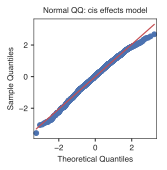

In [52]:
res = mod.resid

fig, ax = plt.subplots(figsize=(2.2, 2.2), ncols=1, nrows=1)
sm.qqplot(res, line='s', ax=ax)
ax.set_title("Normal QQ: cis effects model")
# fig.savefig("avg_activ_qq.pdf", dpi="figure", bbox_inches="tight")

In [53]:
reduced_llf = mod.llf
reduced_llf

-2384.1127081112331

In [54]:
reduced_rsq = mod.rsquared
reduced_rsq

0.03249651303540424

## 6. add motifs to model

In [55]:
len(data_filt)

1655

In [56]:
data_filt["hg19_index"] = data_filt["hg19_id"] + "__" + data_filt["tss_tile_num"]
data_filt["mm9_index"] = data_filt["mm9_id"] + "__" + data_filt["tss_tile_num"]

In [57]:
human_df["hg19_index"] = human_df["hg19_id"] + "__" + human_df["tss_tile_num"]
mouse_df["mm9_index"] = mouse_df["mm9_id"] + "__" + mouse_df["tss_tile_num"]

In [58]:
def motif_disrupted(row):
    if row["motif_sum"] == 1:
        return "c - disrupted"
    elif row["motif_sum"] == 0:
        return "b - not present"
    else:
        return "a - maintained"

In [59]:
len(human_df[human_df["tss_tile_num"] == "tile2"]["hg19_id"].unique())

595

In [60]:
motif_results = {}

for i, motif_id in enumerate(uniq_motifs):
    tmp = data_filt.copy()
    
    # determine whether motif is in human or mouse sequence
    human_motifs_sub = human_df[human_df["#pattern name"] == motif_id]["hg19_index"].unique()
    mouse_motifs_sub = mouse_df[mouse_df["#pattern name"] == motif_id]["mm9_index"].unique()
    tmp["hg19_motif"] = tmp["hg19_index"].isin(human_motifs_sub)
    tmp["mm9_motif"] = tmp["mm9_index"].isin(mouse_motifs_sub)
    
    tmp["motif_sum"] = tmp[["hg19_motif", "mm9_motif"]].sum(axis=1)
    #tmp = tmp[tmp["motif_sum"] >= 1]
    tmp["motif_disrupted"] = tmp.apply(motif_disrupted, axis=1)
    n_maintained = len(tmp[tmp["motif_disrupted"] == "a - maintained"])
    
    # make reduced model
    mod = smf.ols(formula='box_abs_logFC_cis ~ mean_gc + mean_cpg + abs_delta_gc + abs_delta_cpg', 
                  data=tmp).fit()
    reduced_llf = mod.llf
    reduced_rsq = mod.rsquared
    
    # make full model
    full_mod = smf.ols(formula='box_abs_logFC_cis ~ mean_gc + mean_cpg + abs_delta_gc + abs_delta_cpg + motif_disrupted', 
                       data=tmp).fit()
    full_llf = full_mod.llf
    full_rsq = full_mod.rsquared
    
    # perform likelihood ratio test
    lr, p = lrtest(reduced_llf, full_llf)
    
    # calculate additional variance explained
    rsq = full_rsq - reduced_rsq
    
    # record beta
    beta = list(full_mod.params)[2]
    
    # beta p
    beta_p = list(full_mod.pvalues)[2]
    
    print("(#%s) %s: n w/ motif: %s ... p: %s, rsquared: %s" % (i+1, motif_id, len(tmp), p, rsq))
    motif_results[motif_id] = {"lr_test": lr, "pval": p, "rsq": rsq, "beta": beta, "beta_p": beta_p,
                               "n_maintained": n_maintained}

(#1) ZNF785: n w/ motif: 1655 ... p: 0.844251563325, rsquared: 2.25626290824e-05
(#2) ZNF235: n w/ motif: 1655 ... p: 0.00613807619262, rsquared: 0.00437995729871
(#3) ZNF432: n w/ motif: 1655 ... p: 0.328981109437, rsquared: 0.000556902090499
(#4) ZNF93: n w/ motif: 1655 ... p: 0.358870529943, rsquared: 0.000492010764848
(#5) ZNF487: n w/ motif: 1655 ... p: 0.0810341792154, rsquared: 0.00177789080829
(#6) M10350_1: n w/ motif: 1655 ... p: 0.692728380364, rsquared: 9.12786849554e-05
(#7) ZNF304: n w/ motif: 1655 ... p: 0.342329419219, rsquared: 0.000526978227619
(#8) ZNF880: n w/ motif: 1655 ... p: 0.248021517554, rsquared: 0.000779776217951
(#9) M08865_1: n w/ motif: 1655 ... p: 0.509460836534, rsquared: 0.000254366977755
(#10) ZNF180: n w/ motif: 1655 ... p: 0.299141006647, rsquared: 0.000629998860651
(#11) ZNF780A: n w/ motif: 1655 ... p: 0.286010365531, rsquared: 0.000665218895364
(#12) M08863_1: n w/ motif: 1655 ... p: 0.677890440705, rsquared: 0.000100843242544
(#13) M09371_1: n 

(#101) ZNF417: n w/ motif: 1655 ... p: 0.0148041573031, rsquared: 0.00346604802427
(#102) M05568_1: n w/ motif: 1655 ... p: 0.0447190839416, rsquared: 0.00235258351576
(#103) M06672_1: n w/ motif: 1655 ... p: 6.58053145535e-07, rsquared: 0.0143519703475
(#104) M08827_1: n w/ motif: 1655 ... p: 0.372538641837, rsquared: 0.000464745507984
(#105) ZNF528: n w/ motif: 1655 ... p: 0.000470967695602, rsquared: 0.00712163536442
(#106) M10405_1: n w/ motif: 1655 ... p: 0.0446468561544, rsquared: 0.0023541738935
(#107) M06854_1: n w/ motif: 1655 ... p: 0.319484888444, rsquared: 0.000579191075057
(#108) M09349_1: n w/ motif: 1655 ... p: 0.148940894913, rsquared: 0.00121698149803
(#109) M06186_1: n w/ motif: 1655 ... p: 0.112025435645, rsquared: 0.0014752161908
(#110) M06131_1: n w/ motif: 1655 ... p: 0.16804884096, rsquared: 0.00111024554003
(#111) M10388_1: n w/ motif: 1655 ... p: 0.469420243834, rsquared: 0.0003058934041
(#112) M06795_1: n w/ motif: 1655 ... p: 0.70604314195, rsquared: 8.316162

(#200) M05766_1: n w/ motif: 1655 ... p: 0.208353242232, rsquared: 0.000924872129938
(#201) ZNF587: n w/ motif: 1655 ... p: 0.242340778735, rsquared: 0.00079876704791
(#202) M06241_1: n w/ motif: 1655 ... p: 0.487562673372, rsquared: 0.000281675320882
(#203) M10440_1: n w/ motif: 1655 ... p: 0.148216102643, rsquared: 0.00122133150286
(#204) M05982_1: n w/ motif: 1655 ... p: 0.000607070450379, rsquared: 0.00684707727686
(#205) M09267_1: n w/ motif: 1655 ... p: 0.297955699905, rsquared: 0.00063309629597
(#206) M09265_1: n w/ motif: 1655 ... p: 0.296789048366, rsquared: 0.000636160470171
(#207) M09241_1: n w/ motif: 1655 ... p: 0.246239000486, rsquared: 0.000785677571943
(#208) M09237_1: n w/ motif: 1655 ... p: 0.468558941861, rsquared: 0.000307080915625
(#209) ZNF708: n w/ motif: 1655 ... p: 0.00185746420542, rsquared: 0.00564544505345
(#210) M08656_1: n w/ motif: 1655 ... p: 0.00123347956427, rsquared: 0.00608367017792
(#211) M08883_1: n w/ motif: 1655 ... p: 0.771726051846, rsquared: 4

(#298) M08469_1: n w/ motif: 1655 ... p: 0.336477985318, rsquared: 0.000539900166498
(#299) M02098_1: n w/ motif: 1655 ... p: 7.54762228981e-05, rsquared: 0.00911641217242
(#300) M00878_1: n w/ motif: 1655 ... p: 0.0158839466868, rsquared: 0.00339384429922
(#301) M00267_1: n w/ motif: 1655 ... p: 0.317877521283, rsquared: 0.000583050213658
(#302) M06221_1: n w/ motif: 1655 ... p: 0.146520165613, rsquared: 0.00123160452218
(#303) M06135_1: n w/ motif: 1655 ... p: 0.0300966377871, rsquared: 0.00274588936081
(#304) M05938_1: n w/ motif: 1655 ... p: 0.499164099801, rsquared: 0.000266955054487
(#305) M09001_1: n w/ motif: 1655 ... p: 0.284667869142, rsquared: 0.000668935649183
(#306) M09123_1: n w/ motif: 1655 ... p: 0.474457350513, rsquared: 0.000299018255852
(#307) M09121_1: n w/ motif: 1655 ... p: 0.436574729776, rsquared: 0.000353772031806
(#308) M06390_1: n w/ motif: 1655 ... p: 0.117860070994, rsquared: 0.00142858703544
(#309) M05936_1: n w/ motif: 1655 ... p: 0.379047126156, rsquared

(#396) M05787_1: n w/ motif: 1655 ... p: 0.526590894266, rsquared: 0.000234373914207
(#397) ZNF263: n w/ motif: 1655 ... p: 0.000427660475995, rsquared: 0.00722611146657
(#398) M09872_1: n w/ motif: 1655 ... p: 0.129394564355, rsquared: 0.00134348879421
(#399) M05924_1: n w/ motif: 1655 ... p: 0.425645151512, rsquared: 0.000370957039529
(#400) M08953_1: n w/ motif: 1655 ... p: 0.528562862123, rsquared: 0.000232145932321
(#401) M10400_1: n w/ motif: 1655 ... p: 0.0704892809852, rsquared: 0.00191066349926
(#402) M10410_1: n w/ motif: 1655 ... p: 0.00171601886464, rsquared: 0.00573006760262
(#403) M10323_1: n w/ motif: 1655 ... p: 0.0363619153648, rsquared: 0.00255716713895
(#404) M08719_1: n w/ motif: 1655 ... p: 0.165414710971, rsquared: 0.00112411463468
(#405) M00880_1: n w/ motif: 1655 ... p: 0.0725201151832, rsquared: 0.00188350290234
(#406) M00402_1: n w/ motif: 1655 ... p: 0.0290264393793, rsquared: 0.00278219432085
(#407) ZNF684: n w/ motif: 1655 ... p: 0.0101246707247, rsquared: 

In [61]:
motif_results = pd.DataFrame.from_dict(motif_results, orient="index").reset_index()
motif_results = motif_results[motif_results["n_maintained"] >= 10]
print(len(motif_results))
motif_results.head()

342


,index,lr_test,pval,rsq,beta,beta_p,n_maintained
0,HKR1,2.147116,0.142838,0.001254,0.096050,0.159909,424
3,M00226_1,0.157444,0.691521,0.000092,-0.073997,0.762954,24
5,M00255_1,3.745548,0.052948,0.002187,0.239357,0.177634,51
7,M00267_1,0.997659,0.317878,0.000583,-0.058408,0.797294,28
8,M00402_1,4.766045,0.029026,0.002782,-0.179035,0.399543,33


In [62]:
motif_results["padj"] = multicomp.multipletests(motif_results["pval"], method="fdr_bh")[1]
len(motif_results[motif_results["padj"] < 0.05])

63

In [63]:
motif_results["beta_padj"] = multicomp.multipletests(motif_results["beta_p"], method="fdr_bh")[1]
len(motif_results[motif_results["beta_padj"] < 0.05])

17

In [64]:
motif_results.sort_values(by="beta_padj").head(10)

,index,lr_test,pval,rsq,beta,beta_p,n_maintained,padj,beta_padj
57,M05654_1,14.213405,0.000163,0.008273,0.427241,0.000181,133,0.005582,0.047897
68,M05701_1,11.511420,0.000692,0.006706,0.352056,0.000842,169,0.011283,0.047897
400,ZNF263,12.407292,0.000428,0.007226,0.323648,0.000745,160,0.009250,0.047897
181,M08476_1,22.061941,0.000003,0.012812,0.763401,0.000392,27,0.000288,0.047897
180,M08474_1,21.596253,0.000003,0.012543,0.719828,0.000620,28,0.000288,0.047897
20,M00977_1,11.262572,0.000791,0.006562,0.358319,0.000980,163,0.011283,0.047897
417,ZNF528,12.227242,0.000471,0.007122,0.616421,0.000820,35,0.009475,0.047897
66,M05699_1,9.656863,0.001886,0.005629,0.348630,0.002144,154,0.018451,0.049063
313,M09516_1,10.338747,0.001303,0.006025,0.343750,0.001841,145,0.014701,0.049063
312,M09509_1,9.566426,0.001982,0.005576,0.357294,0.002040,139,0.018451,0.049063


## 7. join w/ TF info

In [65]:
motif_results_mrg = motif_results.merge(sig_motifs, on="index", suffixes=("_cis", "_activ"))
motif_results_mrg.sort_values(by="padj_cis").head()

,index,lr_test_cis,pval_cis,rsq_cis,beta_cis,beta_p,n_maintained,padj_cis,beta_padj,lr_test_activ,...,rsq_activ,beta_activ,padj_activ,short_id,HGNC symbol,activ_or_repr,no_CAGE_enr,eRNA_enr,lncRNA_enr,mRNA_enr
110,M06672_1,24.734221,6.580531e-07,0.014352,0.313286,0.005540,191,0.000113,0.067665,632.568434,...,0.037824,0.753912,1.116932e-137,M06672_1,NFYA,activating,NaN,NaN,2.0,3.0
111,M06673_1,25.820870,3.746158e-07,0.014978,0.330035,0.002986,191,0.000113,0.051063,619.411706,...,0.037054,0.735249,7.641777e-135,M06673_1,NFYB,activating,NaN,NaN,2.0,3.0
133,M08474_1,21.596253,3.365085e-06,0.012543,0.719828,0.000620,28,0.000288,0.047897,15.141571,...,0.000926,-0.131019,5.183410e-04,M08474_1,ASCL5,repressing,NaN,1.0,NaN,NaN
132,M08474_1,21.596253,3.365085e-06,0.012543,0.719828,0.000620,28,0.000288,0.047897,15.141571,...,0.000926,-0.131019,5.183410e-04,M08474_1,ASCL4,repressing,NaN,1.0,NaN,NaN
134,M08476_1,22.061941,2.639923e-06,0.012812,0.763401,0.000392,27,0.000288,0.047897,16.272319,...,0.000995,-0.138334,3.007976e-04,M08476_1,ASCL2,repressing,NaN,1.0,NaN,NaN


In [66]:
#sig_results = motif_results_mrg[(motif_results_mrg["padj_cis"] < 0.05) & (motif_results_mrg["beta_cis"] > 0)]
sig_results = motif_results_mrg[(motif_results_mrg["beta_padj"] < 0.05) & (motif_results_mrg["beta_cis"] > 0)]
sig_results = sig_results.sort_values(by="beta_cis", ascending=False)

In [67]:
pal = {"repressing": sns.color_palette("pastel")[3], "activating": sns.color_palette("pastel")[0]}

In [68]:
full_pal = {}
for i, row in sig_results.iterrows():
    full_pal[row["HGNC symbol"]] = pal[row["activ_or_repr"]]

In [69]:
sig_activ = sig_results[sig_results["activ_or_repr"] == "activating"]
sig_repr = sig_results[sig_results["activ_or_repr"] == "repressing"]

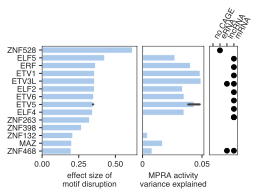

In [70]:
fig = plt.figure(figsize=(3.5, 2))

ax1 = plt.subplot2grid((1, 6), (0, 0), colspan=3)
ax2 = plt.subplot2grid((1, 6), (0, 3), colspan=2)
ax3 = plt.subplot2grid((1, 6), (0, 5), colspan=1)

yvals = []
symbs = []
c = 0
for i, row in sig_activ.iterrows():
    symb = row["HGNC symbol"]
    if symb not in symbs:
        yvals.append(c)
        symbs.append(symb)
        c += 1
    else:
        yvals.append(c)

sig_activ["yval"] = yvals
sns.barplot(y="HGNC symbol", x="beta_cis", data=sig_activ, palette=full_pal, ax=ax1)
ax1.set_ylabel("")
ax1.set_xlabel("effect size of\nmotif disruption")

sns.barplot(y="HGNC symbol", x="rsq_activ", data=sig_activ, palette=full_pal, ax=ax2)
ax2.set_ylabel("")
ax2.tick_params(left=False, labelleft=False)
ax2.set_xticklabels([0, 0.05])
ax2.set_xlabel("MPRA activity\nvariance explained")

melt = pd.melt(sig_activ, id_vars=["HGNC symbol", "yval"], value_vars=["no_CAGE_enr", "eRNA_enr",
                                                                                 "lncRNA_enr", "mRNA_enr"])
ax3.plot(melt["value"], melt["yval"], 'o', color="black")
ax3.set_xlim((-0.5, 3.5))
ax3.set_ylim((np.max(yvals)-0.5, -0.5))
ax3.tick_params(labelleft=False, labelbottom=False, bottom=False, left=False, top=True, labeltop=True)
ax3.xaxis.set_ticks([0, 1, 2, 3])
ax3.set_xticklabels(["no CAGE", "eRNA", "lncRNA", "mRNA"], rotation=60, ha="left", va="bottom")

plt.show()
fig.savefig("Fig3B.pdf", dpi="figure", bbox_inches="tight")
plt.close()

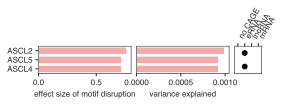

In [71]:
fig = plt.figure(figsize=(4, 0.5))

ax1 = plt.subplot2grid((1, 7), (0, 0), colspan=3)
ax2 = plt.subplot2grid((1, 7), (0, 3), colspan=3)
ax3 = plt.subplot2grid((1, 7), (0, 6), colspan=1)

yvals = []
symbs = []
c = 0
for i, row in sig_repr.iterrows():
    symb = row["HGNC symbol"]
    if symb not in symbs:
        yvals.append(c)
        symbs.append(symb)
        c += 1
    else:
        yvals.append(c)

sig_repr["yval"] = yvals
sns.barplot(y="HGNC symbol", x="beta_cis", data=sig_repr, palette=full_pal, ax=ax1)
ax1.set_ylabel("")
ax1.set_xlabel("effect size of motif disruption")

sns.barplot(y="HGNC symbol", x="rsq_activ", data=sig_repr, palette=full_pal, ax=ax2)
ax2.set_ylabel("")
ax2.tick_params(left=False, labelleft=False)
ax2.set_xlabel("variance explained")

melt = pd.melt(sig_repr, id_vars=["HGNC symbol", "yval"], value_vars=["no_CAGE_enr", "eRNA_enr",
                                                                                 "lncRNA_enr", "mRNA_enr"])
ax3.plot(melt["value"], melt["yval"], 'o', color="black")
ax3.set_xlim((-0.5, 3.5))
ax3.set_ylim((np.max(yvals)-0.5, -0.5))
ax3.tick_params(labelleft=False, labelbottom=False, bottom=False, left=False, top=True, labeltop=True)
ax3.xaxis.set_ticks([0, 1, 2, 3])
ax3.set_xticklabels(["no CAGE", "eRNA", "lncRNA", "mRNA"], rotation=60, ha="left", va="bottom")

plt.show()
fig.savefig("FigS10.pdf", dpi="figure", bbox_inches="tight")
plt.close()

In [72]:
data_filt = data_elem[((data_elem["HUES64_padj_hg19"] < QUANT_ALPHA) | (data_elem["mESC_padj_mm9"] < QUANT_ALPHA))]
print(len(data_filt))
# data_filt = data_filt[data_filt["tss_tile_num"] == "tile1"].drop("orig_species", axis=1).drop_duplicates()
# len(data_filt)

1655


In [73]:
data_filt_sp = data_filt.drop("orig_species", axis=1)
data_filt_sp.drop_duplicates(inplace=True)
len(data_filt_sp)

1644

In [74]:
data_filt_sp["hg19_index"] = data_filt_sp["hg19_id"] + "__" + data_filt_sp["tss_tile_num"]
data_filt_sp["mm9_index"] = data_filt_sp["mm9_id"] + "__" + data_filt_sp["tss_tile_num"]

In [75]:
def uniq_motif(row):
    if row.hg19_motif == True:
        if row.mm9_motif == True:
            return "maintained"
        else:
            return "disrupted in mouse"
    else:
        if row.mm9_motif == True:
            return "disrupted in human"
        else:
            return "not present"

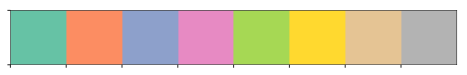

In [76]:
sns.palplot(sns.color_palette("Set2"))

0.804492748801
0.649960097714


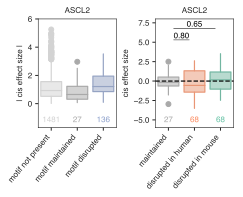

0.803232245781
0.591804786103


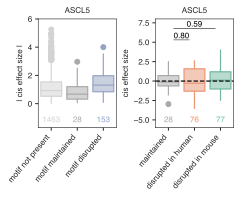

0.343062892053
0.942009165339


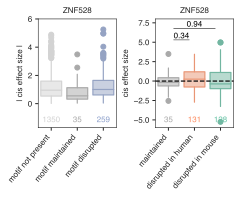

0.0436983854294
0.0140015826547


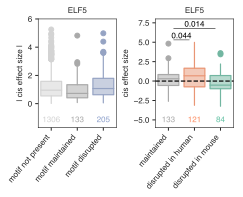

7.26176383691e-07
0.00019355059113


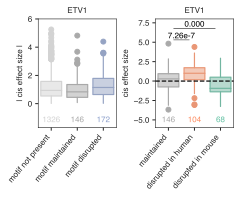

1.23094038712e-07
0.00112071302015


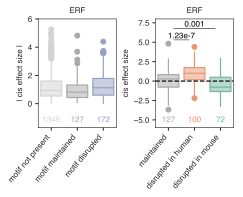

In [77]:
# plot some examples
examps = ["ASCL2", "ASCL5", "ZNF528", "ELF5", "ETV1", "ERF"]
order1 = ["b - not present", "a - maintained", "c - disrupted"]
order2 = ["maintained", "disrupted in human", "disrupted in mouse"]
pal1 = {"b - not present": "lightgray", "a - maintained": "darkgray", "c - disrupted": sns.color_palette("Set2")[2]}
pal2 = {"maintained": "darkgray", "disrupted in human": sns.color_palette("Set2")[1], 
        "disrupted in mouse": sns.color_palette("Set2")[0]}

for symb in examps:
    motif_id = sig_results[sig_results["HGNC symbol"] == symb]["index"].iloc[0]
    
    tmp = data_filt_sp.copy()
    
    # determine whether motif is in human or mouse sequence
    human_motifs_sub = human_df[human_df["#pattern name"] == motif_id]["hg19_index"].unique()
    mouse_motifs_sub = mouse_df[mouse_df["#pattern name"] == motif_id]["mm9_index"].unique()
    tmp["hg19_motif"] = tmp["hg19_index"].isin(human_motifs_sub)
    tmp["mm9_motif"] = tmp["mm9_index"].isin(mouse_motifs_sub)
    
    tmp["motif_sum"] = tmp[["hg19_motif", "mm9_motif"]].sum(axis=1)
    #tmp = tmp[tmp["motif_sum"] >= 1]
    tmp["motif_disrupted"] = tmp.apply(motif_disrupted, axis=1)
    tmp["uniq_motif"] = tmp.apply(uniq_motif, axis=1)
    
    fig, axarr = plt.subplots(figsize=(3.5, 2), nrows=1, ncols=2)
    
    ax = axarr[0]
    sns.boxplot(data=tmp, x="motif_disrupted", y="abs_logFC_cis", order=order1, palette=pal1, 
                flierprops = dict(marker='o', markersize=5), ax=ax)
    mimic_r_boxplot(ax)
    ax.set_xticklabels(["motif not present", "motif maintained", "motif disrupted"], rotation=50, 
                       ha="right", va="top")
    ax.set_ylabel("| cis effect size |")
    ax.set_title(symb)
    ax.set_xlabel("")
    
    for i, label in enumerate(order1):
        n = len(tmp[tmp["motif_disrupted"] == label])
        ax.annotate(str(n), xy=(i, -0.9), xycoords="data", xytext=(0, 0), 
                    textcoords="offset pixels", ha='center', va='top', 
                    color=pal1[label], size=fontsize)

    ax.set_ylim((-1.7, 6))

    ax = axarr[1]
    sns.boxplot(data=tmp, x="uniq_motif", y="logFC_cis_one", order=order2, palette=pal2,
                flierprops = dict(marker='o', markersize=5), ax=ax)
    ax.set_xticklabels(order2, rotation=50, ha="right", va="top")
    mimic_r_boxplot(ax)
    ax.set_ylabel("cis effect size")
    ax.set_title(symb)
    ax.set_xlabel("")
    ax.axhline(y=0, linestyle="dashed", color="black", zorder=100)
    
    for i, label in enumerate(order2):
        n = len(tmp[tmp["uniq_motif"] == label])
        ax.annotate(str(n), xy=(i, -5.5), xycoords="data", xytext=(0, 0), 
                    textcoords="offset pixels", ha='center', va='bottom', 
                    color=pal2[label], size=fontsize)
        
    # calc p-vals b/w dists
    dist1 = np.asarray(tmp[tmp["uniq_motif"] == "maintained"]["logFC_cis_one"])
    dist2 = np.asarray(tmp[tmp["uniq_motif"] == "disrupted in human"]["logFC_cis_one"])
    dist3 = np.asarray(tmp[tmp["uniq_motif"] == "disrupted in mouse"]["logFC_cis_one"])

    dist1 = dist1[~np.isnan(dist1)]
    dist2 = dist2[~np.isnan(dist2)]
    dist3 = dist3[~np.isnan(dist3)]

    u, pval1 = stats.mannwhitneyu(dist1, dist2, alternative="two-sided", use_continuity=False)
    u, pval2 = stats.mannwhitneyu(dist1, dist3, alternative="two-sided", use_continuity=False)
    print(pval1)
    print(pval2)

    annotate_pval(ax, 0.2, 0.8, 5.3, 0, 5.3, pval1, fontsize)
    annotate_pval(ax, 0.2, 1.8, 6.8, 0, 6.8, pval2, fontsize)

    ax.set_ylim((-6, 8))
    
    plt.subplots_adjust(wspace=0.5)
    if symb == "ETV1":
        fig.savefig("Fig3C.pdf", dpi="figure", bbox_inches="tight")
    plt.show()

## 8. for every sequence pair, calculate the # identical motifs, the # motifs that fully turn over, and the # motifs that partially turn over

defined as:
- identical motifs = identical sequence in both species
- full turnover = motifs that are only present in one species
- partial turnover = motifs that are in both species but don't map to the exact same sequence

In [78]:
print(len(data))
data.tss_tile_num.value_counts()

2952


tile1    2352
tile2     600
Name: tss_tile_num, dtype: int64

In [79]:
turnover_results = {}

for i, row in data.iterrows():
    if i % 100 == 0:
        print("...# %s..." % (i+1))

    human_id = row["hg19_id"]
    mouse_id = row["mm9_id"]
    tile_num = row["tss_tile_num"]
    
    human_motifs_sub = human_df[(human_df["hg19_id"] == human_id) & (human_df["tss_tile_num"] == tile_num)]
    mouse_motifs_sub = mouse_df[(mouse_df["mm9_id"] == mouse_id) & (mouse_df["tss_tile_num"] == tile_num)]
    
    # find total number of unique motifs (in both species)
    human_motif_ids = list(human_motifs_sub["#pattern name"].unique())
    mouse_motif_ids = list(mouse_motifs_sub["#pattern name"].unique())
    total_uniq_motifs = len(set(human_motif_ids + mouse_motif_ids))
    
    # find difference in motifs b/w the two species
    delta_motifs = len(mouse_motif_ids) - len(human_motif_ids)
    
    # find number of motifs that are in both species
    merge_sub = human_motifs_sub[["#pattern name", 
                                  "matched sequence"]].merge(mouse_motifs_sub[["#pattern name", 
                                                                               "matched sequence"]],
                                                             on="#pattern name",
                                                             suffixes=(" human", " mouse"))
    merge_sub = merge_sub.drop_duplicates()
    
    # find number of motifs that are *exactly the same* in both species
    merge_sub["identical"] = merge_sub["matched sequence human"] == merge_sub["matched sequence mouse"]
    
    # since there can be more than one occurrence of the same motif: 
    # if there is at least 1 instance of an identical motif, call it identical
    # otherwise, call it partial
    # to do this, sort the df and keep the first occurrence (which will always = True if it's there)
    merge_sub = merge_sub.sort_values(by=["#pattern name", 
                                          "identical"], ascending=False)[["#pattern name", "identical"]]
    merge_sub = merge_sub.drop_duplicates(subset="#pattern name")
    total_in_both = len(merge_sub)
    
    n_identical = len(merge_sub[merge_sub["identical"]])
    
    # find number that are partially different
    n_partial = len(merge_sub[~merge_sub["identical"]])
    
    # find number of motifs that fully turn over between species (i.e. are in only one species)
    n_human_uniq = len(set(human_motif_ids).difference(set(mouse_motif_ids)))
    n_mouse_uniq = len(set(mouse_motif_ids).difference(set(human_motif_ids)))
    n_turnover = n_human_uniq + n_mouse_uniq
    
    turnover_results["%s__%s__%s" % (human_id, mouse_id, tile_num)] = {"total_motifs": total_uniq_motifs,
                                                                       "total_shared_motifs": total_in_both,
                                                                       "n_identical_motifs": n_identical,
                                                                       "n_partial_motifs": n_partial,
                                                                       "n_turnover_motifs": n_turnover,
                                                                       "delta_motifs": delta_motifs}

...# 1...
...# 101...
...# 201...
...# 301...
...# 401...
...# 501...
...# 601...
...# 701...
...# 801...
...# 901...
...# 1001...
...# 1101...
...# 1201...
...# 1301...
...# 1401...
...# 1501...
...# 1601...
...# 1701...
...# 1801...
...# 1901...
...# 2001...
...# 2101...
...# 2201...
...# 2301...
...# 2401...
...# 2501...
...# 2601...
...# 2701...
...# 2801...
...# 2901...


In [80]:
turnover_df = pd.DataFrame.from_dict(turnover_results, orient="index").reset_index()

# split index column to separate id columns
turnover_df["hg19_id"] = turnover_df["index"].str.split("__", expand=True)[0]
turnover_df["mm9_id"] = turnover_df["index"].str.split("__", expand=True)[1]
turnover_df["tss_tile_num"] = turnover_df["index"].str.split("__", expand=True)[2]

# calculate percentages
turnover_df["perc_shared_motifs"] = (turnover_df["total_shared_motifs"]/turnover_df["total_motifs"])*100
turnover_df["perc_identical_motifs"] = (turnover_df["n_identical_motifs"]/turnover_df["total_shared_motifs"])*100
turnover_df["perc_partial_motifs"] = (turnover_df["n_partial_motifs"]/turnover_df["total_shared_motifs"])*100
turnover_df["perc_turnover_motifs"] = (turnover_df["n_turnover_motifs"]/turnover_df["total_motifs"])*100
turnover_df["abs_delta_motifs"] = np.abs(turnover_df["delta_motifs"])

turnover_df.head()

,index,total_motifs,total_shared_motifs,n_identical_motifs,n_partial_motifs,n_turnover_motifs,delta_motifs,hg19_id,mm9_id,tss_tile_num,perc_shared_motifs,perc_identical_motifs,perc_partial_motifs,perc_turnover_motifs,abs_delta_motifs
0,h.1000__m.883__tile1,135,55,1,54,80,42,h.1000,m.883,tile1,40.740741,1.818182,98.181818,59.259259,42
1,h.1001__m.884__tile2,129,75,26,49,54,-20,h.1001,m.884,tile2,58.139535,34.666667,65.333333,41.860465,20
2,h.1002__m.885__tile2,77,42,14,28,35,-23,h.1002,m.885,tile2,54.545455,33.333333,66.666667,45.454545,23
3,h.1003__m.886__tile1,83,18,8,10,65,11,h.1003,m.886,tile1,21.686747,44.444444,55.555556,78.313253,11
4,h.1004__m.887__tile2,101,56,1,55,45,1,h.1004,m.887,tile2,55.445545,1.785714,98.214286,44.554455,1


## 9. merge motif turnover data w/ cis effects

In [81]:
data_motifs = data.merge(turnover_df, on=["hg19_id", "mm9_id", "tss_tile_num"], how="left")
print(len(data_motifs))
data_motifs.head()

2952


,hg19_id,chr_tss_hg19,start_tss_hg19,biotype_hg19,cage_id_hg19,name_peak_hg19,minimal_biotype_hg19,stem_exp_hg19,mm9_id,chr_tss_mm9,...,total_shared_motifs,n_identical_motifs,n_partial_motifs,n_turnover_motifs,delta_motifs,perc_shared_motifs,perc_identical_motifs,perc_partial_motifs,perc_turnover_motifs,abs_delta_motifs
0,h.2,chr1,2985430.0,divergent,"chr1:2985420..2985438,-",ENSG00000177133.6,lncRNA,0.07111110000000001,m.1,chr4,...,41,21,20,34,-16,54.666667,51.219512,48.780488,45.333333,16
1,h.3,chr1,8086552.0,divergent,"chr1:8086546..8086571,+",ENSG00000238290.1,lncRNA,0.10444400000000001,m.2,chr4,...,22,2,20,91,47,19.469027,9.090909,90.909091,80.530973,47
2,h.4,chr1,26498322.0,antisense,"chr1:26498321..26498327,-",ENSG00000236782.1,other,0.03,m.3,chr4,...,50,5,45,35,1,58.823529,10.000000,90.000000,41.176471,1
3,h.5,chr1,65533428.0,intergenic,"chr1:65533390..65533443,-",ENSG00000231485.1,lncRNA,0.841111,m.4,chr4,...,60,36,24,45,27,57.142857,60.000000,40.000000,42.857143,27
4,h.6,chr1,65533462.0,intergenic,"chr1:65533457..65533465,-",ENSG00000231485.1,lncRNA,0.116667,m.4,chr4,...,46,33,13,57,43,44.660194,71.739130,28.260870,55.339806,43


## 6. filter data

In [82]:
data_filt = data_motifs[((data_motifs["HUES64_padj_hg19"] < QUANT_ALPHA) | (data_motifs["mESC_padj_mm9"] < QUANT_ALPHA))]
len(data_filt)

1655

In [83]:
data_filt_sp = data_filt.drop("orig_species", axis=1)
data_filt_sp.drop_duplicates(inplace=True)
len(data_filt_sp)

1644

## 7. plot cis effects v motif turnover

In [84]:
order = ["no cis effect", "significant cis effect"]
palette = {"no cis effect": "gray", "significant cis effect": sns.color_palette("Set2")[2]}

### % shared motifs

In [85]:
df = data_filt_sp

5.66567438161e-12


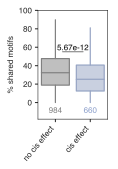

In [86]:
fig = plt.figure(figsize=(1.25, 2))
ax = sns.boxplot(data=df, x="cis_status_one", y="perc_shared_motifs", palette=palette, order=order,
                 flierprops = dict(marker='o', markersize=5))
mimic_r_boxplot(ax)

ax.set_xticklabels(["no cis effect", 'cis effect'], rotation=50, ha='right', va='top')
ax.set_xlabel("")
ax.set_ylabel("% shared motifs")

for i, l in enumerate(order):
    n = len(df[df["cis_status_one"] == l])
    ax.annotate(str(n), xy=(i, -5), xycoords="data", xytext=(0, 0), 
                textcoords="offset pixels", ha='center', va='top', 
                color=palette[l], size=fontsize)

ax.set_ylim((-18, 100))

# calc p-vals b/w dists
dist1 = np.asarray(df[df["cis_status_one"] == "no cis effect"]["perc_shared_motifs"])
dist2 = np.asarray(df[df["cis_status_one"] != "no cis effect"]["perc_shared_motifs"])

dist1 = dist1[~np.isnan(dist1)]
dist2 = dist2[~np.isnan(dist2)]

u, pval = stats.mannwhitneyu(dist1, dist2, alternative="two-sided", use_continuity=False)
print(pval)

annotate_pval(ax, 0.2, 0.8, 55, 0, 55, pval, fontsize)

plt.show()
fig.savefig("Fig3A.pdf", dpi="figure", bbox_inches="tight")
plt.close()

## 8. write motif files

In [87]:
len(human_df)

229713

In [88]:
len(mouse_df)

215682

In [89]:
human_f = "../../../data/04__mapped_motifs/human_motifs_filtered.txt.gz"
human_df.to_csv(human_f, sep="\t", index=False, compression="gzip")

In [90]:
mouse_f = "../../../data/04__mapped_motifs/mouse_motifs_filtered.txt.gz"
mouse_df.to_csv(mouse_f, sep="\t", index=False, compression="gzip")